<a href="https://colab.research.google.com/github/aleksho/hack_nn_cp_202106/blob/main/aleksho%20/hack_nn_cp_202106/book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
import spacy
from nltk import word_tokenize 
from nltk.util import ngrams
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
 
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 
 
np.random.seed(1)
from google.colab import drive
import os
drive.mount('/content/drive')
HOMEDIR='drive/MyDrive/workds'
HOMEDIR='drive/MyDrive/workds'
MODELDIR=f'{HOMEDIR}/models/hack_2021_06'
os.makedirs(f"{MODELDIR}",exist_ok= True )

arx_10000 = f'{MODELDIR}/arx_10000_machine_learning.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install arxivscraper

In [ ]:
import arxivscraper
scraper = arxivscraper.Scraper(category='physics:cond-mat', date_from='2017-05-27',date_until='2018-06-07')

In [ ]:
output = scraper.scrape()

In [ ]:
cols = ('id', 'title', 'categories', 'abstract', 'doi', 'created', 'updated', 'authors')
df = pd.DataFrame(output, columns=cols)

In [ ]:
df.abstract.apply(lambda x: len(x.split()))

0        140
1        168
2         67
3         78
4         93
        ... 
19089    104
19090     44
19091     77
19092     85
19093     73
Name: abstract, Length: 19094, dtype: int64

In [ ]:
df = pd.read_csv(arx_10000)

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
%%time
lemm_abs = []
words_delete = ['the', 'alpha']
for row in np.arange(df.shape[0]):
    doc = nlp(df.loc[row, 'abstract'].strip())
    part_abs = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.like_num and not token.lemma_ in words_delete and not '$' in token.lemma_:
            part_abs.append(token.lemma_)
    lemm_abs.append(part_abs)

CPU times: user 4min 44s, sys: 2.72 s, total: 4min 47s
Wall time: 4min 47s


In [ ]:
import nltk
nltk.download('punkt')

tokens = nltk.word_tokenize(' '.join([' '.join(i) for i in lemm_abs]))

bgs = nltk.bigrams(tokens)

fdist = nltk.FreqDist(bgs)
fdist = dict(sorted(fdist.items(), key=lambda item: -item[1]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
all_keys = list(fdist.keys())

In [ ]:
# fdist

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   abstract   10000 non-null  object
 1   published  10000 non-null  object
 2   title      10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [ ]:
top50 = list(fdist.keys())[:50]

In [ ]:
top50

[('machine', 'learning'),
 ('machine', 'learn'),
 ('neural', 'network'),
 ('deep', 'learning'),
 ('learning', 'model'),
 ('state', 'art'),
 ('reinforcement', 'learning'),
 ('learn', 'algorithm'),
 ('learning', 'method'),
 ('learning', 'algorithm'),
 ('real', 'world'),
 ('paper', 'propose'),
 ('learn', 'model'),
 ('training', 'datum'),
 ('e.g', '.'),
 ('deep', 'neural'),
 ('active', 'learning'),
 ('propose', 'method'),
 ('learning', 'approach'),
 ('experimental', 'result'),
 ('i.e', '.'),
 ('learning', 'technique'),
 ('high', 'dimensional'),
 ('propose', 'novel'),
 ('learning', 'problem'),
 ('transfer', 'learning'),
 ('paper', 'present'),
 ('large', 'scale'),
 ('supervise', 'learning'),
 ('data', 'set'),
 ('loss', 'function'),
 ('learning', 'framework'),
 ('gradient', 'descent'),
 ('supervised', 'learning'),
 ('semi', 'supervised'),
 ('learning', 'base'),
 ('support', 'vector'),
 ('deep', 'learn'),
 ('learning', 'task'),
 ('model', 'base'),
 ('learn', 'task'),
 ('time', 'series'),
 ('me

In [ ]:
top = top50

In [ ]:
df['published'] = pd.to_datetime(df.published)

In [ ]:
min_year = df['published'].min().year
max_year = df['published'].max().year + 1

In [ ]:
time_ser, edges = pd.cut(df['published'], 20, retbins=True)


In [ ]:
from collections import defaultdict

In [ ]:
%%time
dict_bi = defaultdict(list)
for year in range(min_year, max_year):
    cond = (df.published.apply(lambda x: x.year) == year)
#     print(cond.sum())
    temp_lemm = pd.Series(lemm_abs)[cond]
    tokens = nltk.word_tokenize(' '.join([' '.join(i) for i in temp_lemm]))
    
    bgs = nltk.bigrams(tokens)
    
    fdist = nltk.FreqDist(bgs)
    fdist = dict(sorted(fdist.items(), key=lambda item: -item[1]))
    for i in all_keys:
        try:
            dict_bi[i].append(fdist[i])
        except:
            dict_bi[i].append(0)

CPU times: user 19.3 s, sys: 234 ms, total: 19.5 s
Wall time: 19.5 s


In [ ]:
df_top_bi = pd.DataFrame(dict_bi)

In [ ]:
df_top_bi.columns = [' '.join(i) for i in df_top_bi.columns]

Но надо бы получше поставить индекс

In [ ]:
year_pub_counts = df.published.apply(lambda x: x.year).value_counts()

In [ ]:
year_sorted = sorted(year_pub_counts.index.to_list())

In [ ]:
df_top_bi.index = year_sorted

In [ ]:
df_top_bi_adj = df_top_bi.multiply(1 / year_pub_counts, axis='index')

Пока что мусорно, но виден в конце отчётливый тренд

In [ ]:
df_top_bi_adj.loc[2021]

machine       learning       0.951306
              learn          0.528504
neural        network        0.280285
deep          learning       0.207838
learning      model          0.217340
                               ...   
snapshot      information    0.000000
performance   DOA            0.000000
grid          problem        0.000000
problem       array          0.000000
imperfection  exist          0.000000
Name: 2021, Length: 405837, dtype: float64

In [ ]:
df_top_bi_adj.plot(figsize=(10, 8))
plt.grid(alpha=.4)

In [ ]:
'Monte Carlo' in df_top_bi_adj.columns 

True

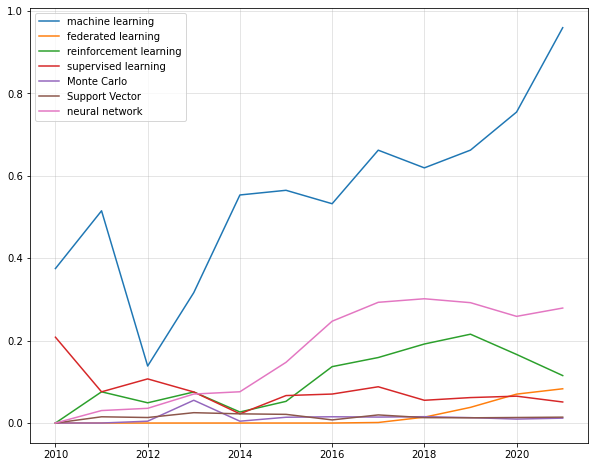

In [ ]:
# plt.figure(figsize=(10, 8))
df_top_bi_adj.loc[2010:, ['machine learning', 'federated learning', 'reinforcement learning', 'supervised learning', 'Monte Carlo', 'Support Vector', 'neural network']].plot(figsize=(10, 8))
plt.grid(alpha=.4)

### Как найти выдающиеся темы (фронтиры)?

In [ ]:
%%time
dict_bi = defaultdict(list)
for year in range(2010, max_year):
    cond = (df.published.apply(lambda x: x.year) == year)
    temp_lemm = pd.Series(lemm_abs)[cond]
    tokens = nltk.word_tokenize(' '.join([' '.join(i) for i in temp_lemm]))
    
    bgs = nltk.bigrams(tokens)
    
    fdist = nltk.FreqDist(bgs)
    fdist = dict(sorted(fdist.items(), key=lambda item: -item[1]))
    for i in all_keys:
        try:
            dict_bi[i].append(fdist[i])
        except:
            dict_bi[i].append(0)

Wall time: 7.72 s


In [ ]:
len(edges)

21

### Добавить относительные метрики, чтобы поднять слабые сигналы?

In [ ]:
def get_front(name, dict_edges):
    total = 0
    for i in range(len(edges) - 1):
        coef = i / (len(edges) - 1)
        total += coef * dict_edges[name][i]
    return total


def get_front_rise(name, dict_edges):
    total_rise = 0
    for i in range(len(edges) - 1):
        if dict_edges[name][i + 1] > dict_edges[name][i]:
            total_rise += 1
        else:
            total_rise -= .5
#         coef = i / (len(edges) - 1)
#         total += coef * dict_edges[name][i]
    return total_rise


In [ ]:
dict_front = {}
for i in all_keys:
    dict_front[i] = get_front_rise(i, dict_bi)

IndexError: list index out of range

In [ ]:
# print(pd.Series(dict_front).sort_values(ascending=True)[-150:].to_string())

In [ ]:
topics = [' '.join(i) for i in list(pd.Series(dict_front).sort_values(ascending=False).index)[:10]]
# plt.figure(figsize=(10, 8))
df_top_bi_adj.loc[2010:, topics].plot(figsize=(10, 8))
plt.grid(alpha=.4)

<AxesSubplot:>

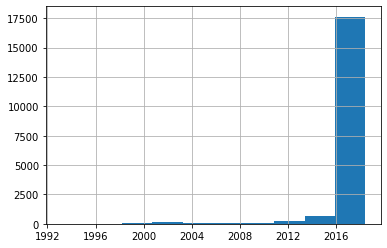

In [ ]:
df.created.hist()

In [ ]:
with open('lotr.txt', encoding='utf-8') as f:
    book = f.read().splitlines()

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
%%time
lemm_book = []
words_delete = ['say', 'come', 'look', 'the']
for part in book:
    doc = nlp(part)
    part_list = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.like_num and not token.lemma_ in words_delete:
            part_list.append(token.lemma_)
    lemm_book.append(part_list)

Wall time: 1min 38s


In [ ]:
# with open('lemm_lotr.txt', 'w', encoding='utf-8') as f:
#     for i in lemm_book:
#         f.write(' '.join(i) + '\n')

In [ ]:
tokens = nltk.word_tokenize(' '.join([' '.join(i) for i in lemm_book]))

#Create your bigrams
bgs = nltk.bigrams(tokens)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist = dict(sorted(fdist.items(), key=lambda item: -item[1]))
# for k,v in fdist.items():
#     if v < 10:
#         break
#     print (k,v)

In [ ]:
# for k,v in fdist.items():
#     if v < 10:
#         break
#     print (k,v)

In [ ]:
for i in fdist.keys():
    print(type(i))
    break

<class 'tuple'>


In [ ]:
len(lemm_book)

10925

In [ ]:
fdist[('Dark', 'Lord')]

50

In [ ]:
dict_lord = {}
for i in range(0, len(lemm_book), 1000):
    tokens = nltk.word_tokenize(' '.join([' '.join(i) for i in lemm_book[i : i + 500]]))
    bgs = nltk.bigrams(tokens)
    fdist = nltk.FreqDist(bgs)
    fdist = dict(sorted(fdist.items(), key=lambda item: -item[1]))
    
    dict_lord[i] = fdist.get(('Middle', 'earth'))

In [ ]:
y = pd.Series(dict_lord.values())
y.fillna(0, inplace=True)
y = list(y)
x = list(dict_lord.keys())

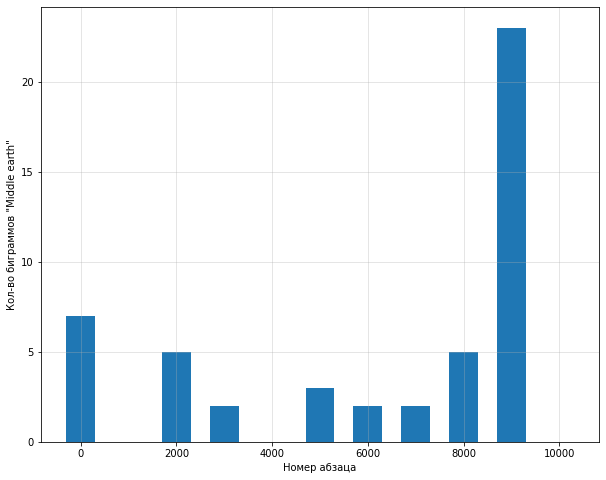

In [ ]:
plt.figure(figsize=(10, 8))
plt.bar(x, y, width=600)
plt.xlabel('Номер абзаца')
plt.ylabel('Кол-во биграммов "Middle earth"')
plt.grid(alpha=.4)
None